### Loading Data

In [23]:
import pandas as pd 
air_passengers = pd.read_csv("../datasets/AirPassengers.csv")

air_passengers.head()


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Data in Glance

In [24]:
air_passengers.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [25]:
air_passengers.shape

(144, 2)

In [26]:
air_passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [27]:
air_passengers['Month'] = pd.to_datetime(air_passengers['Month'], format='%Y-%m')

air_passengers.head()


,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [28]:
air_passengers.index = air_passengers['Month']
del air_passengers['Month']

air_passengers.head()


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Understanding the pattern

<Axes: xlabel='Month'>

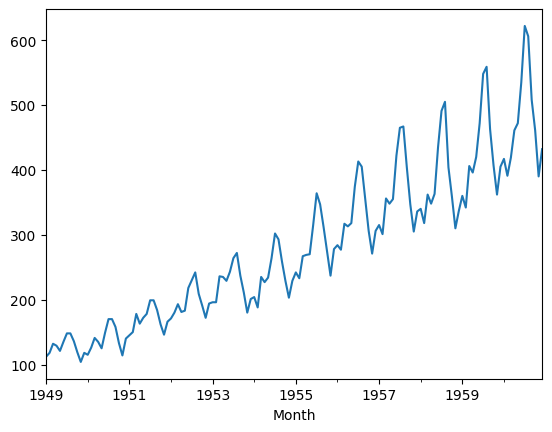

In [29]:
air_passengers['#Passengers'].plot()

### Understanding the pattern with different viz

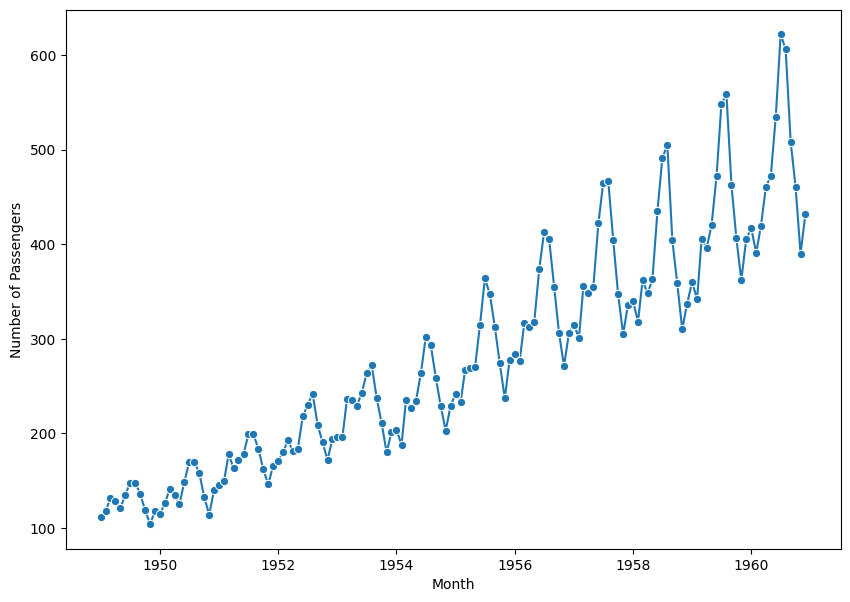

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns 

fig, axes = plt.subplots(figsize=(10,7))
sns.lineplot(data=air_passengers, x=air_passengers.index, y='#Passengers', marker = 'o')
plt.ylabel('Number of Passengers')


plt.show()

### Rolling patterns

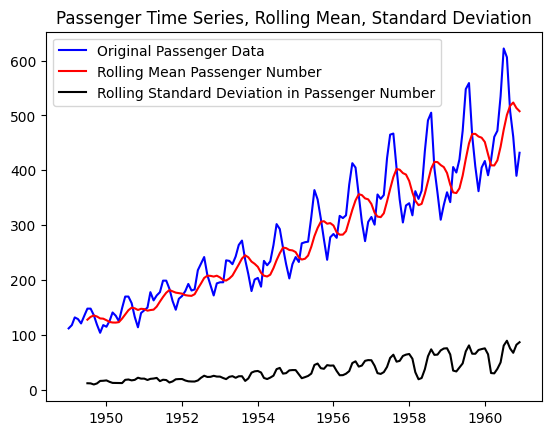

In [31]:
rolling_mean = air_passengers.rolling(7).mean()
rolling_std = air_passengers.rolling(7).std()

plt.plot(air_passengers, color="blue",label="Original Passenger Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

plt.show()

### Adfuller Test

In [32]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(air_passengers,autolag="AIC")

adft_air_passengers = pd.DataFrame({'Values':[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  
                                    , 'Metric':['Test Statistics','p-value','No. of lags used','Number of observations used', 
                                                'critical value (1%)', 'critical value (5%)', 'critical value (10%)']})

print(adft_air_passengers)

       Values                       Metric
0    0.815369              Test Statistics
1    0.991880                      p-value
2   13.000000             No. of lags used
3  130.000000  Number of observations used
4   -3.481682          critical value (1%)
5   -2.884042          critical value (5%)
6   -2.578770         critical value (10%)


### ADF Test function/method from pmdarima

In [33]:
from pmdarima.arima import ADFTest

adf_test = ADFTest()
adf_test.should_diff(air_passengers['#Passengers'])

(0.01, False)

### Autocorrelation for 3 months

In [34]:
lags = [1,3,6,9]

for lag in lags:
    autocorrelation_lag = air_passengers['#Passengers'].autocorr(lag=lag)
    print(autocorrelation_lag)

0.9601946480498523
0.837394765081794
0.7839187959206183
0.8278519011167601


### Decomposition

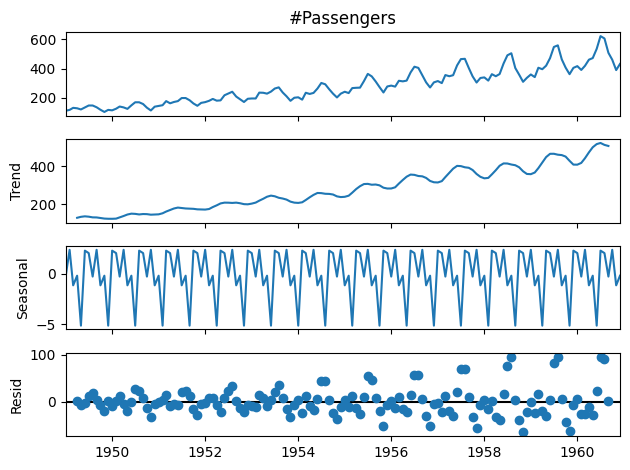

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(air_passengers['#Passengers'],model='additive', period=7)
decompose.plot()

plt.show()

### Develop ARIMA Model

/var/folders/9c/b2pc4s7s5lzf03szjw3x5tk40000gn/T/ipykernel_2456/3184780488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['#Passengers']
/var/folders/9c/b2pc4s7s5lzf03szjw3x5tk40000gn/T/ipykernel_2456/3184780488.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['#Passengers']


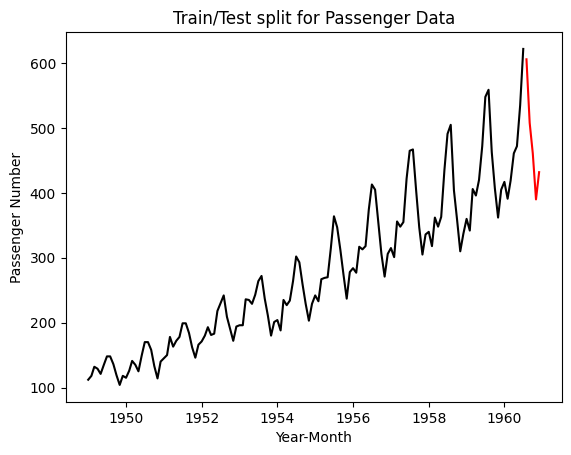

In [36]:
air_passengers['Date'] = air_passengers.index

train = air_passengers[air_passengers['Date'] < pd.to_datetime("1960-08", format='%Y-%m')]
train['train'] = train['#Passengers']
del train['Date']
del train['#Passengers']

test = air_passengers[air_passengers['Date'] >= pd.to_datetime("1960-08", format='%Y-%m')]
del test['Date']
test['test'] = test['#Passengers']
del test['#Passengers']

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')

plt.show()


In [37]:
from pmdarima.arima import auto_arima

model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1352.593, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1340.702, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1336.259, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1352.415, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1329.986, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1335.098, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1336.923, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1329.407, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1335.407, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1339.796, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1325.560, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1336.3

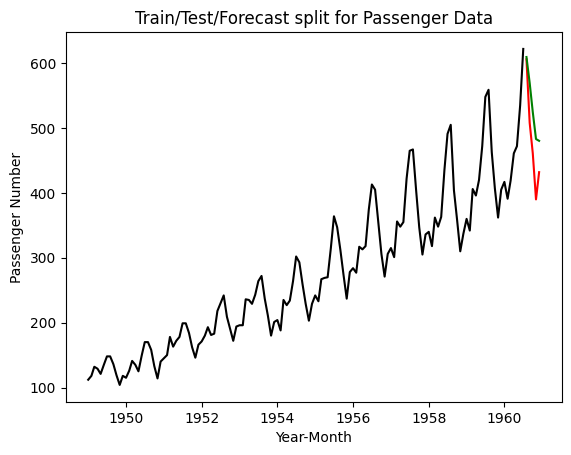

In [38]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast, color = "green")
plt.title("Train/Test/Forecast split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')

plt.show()


### Evaluate our model with Root Mean Squared Error (RMSE) metric

In [39]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)


RMSE:  61.36633338813995


### Use RMSE metric on Linear Regression

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Sample data
X = np.array([[1], [2], [3], [4], [5]])
y = np.array([1, 3, 2, 5, 4])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Square Error: {rmse}")


Root Mean Square Error: 1.142857142857143
